In [2]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from VAN_new import *

## 1. Échantillonnage batché

Dans les modèles autoregressifs, les différentes composantes ne sont pas indépendantes. On va être obligé de les échantillonner une par une.

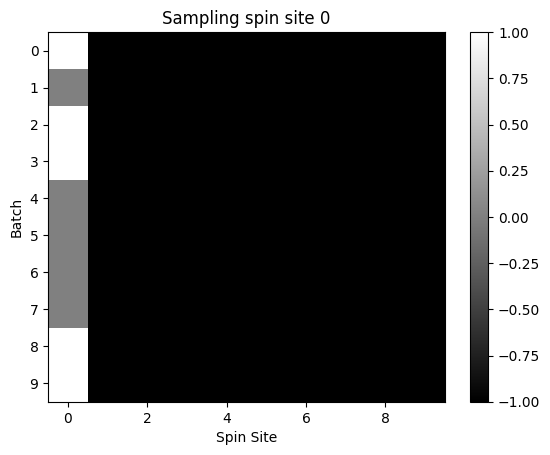

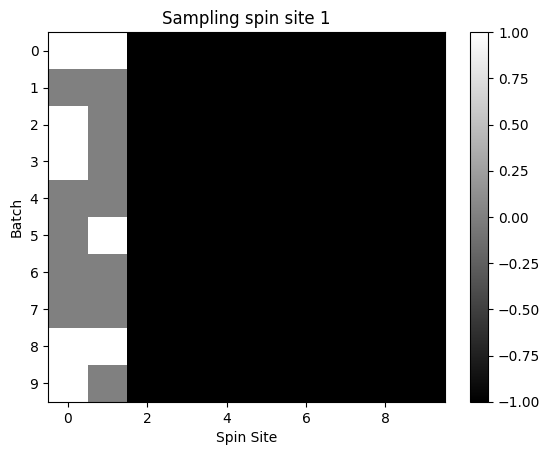

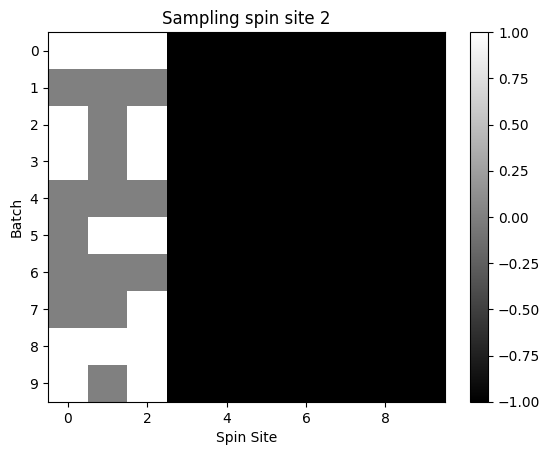

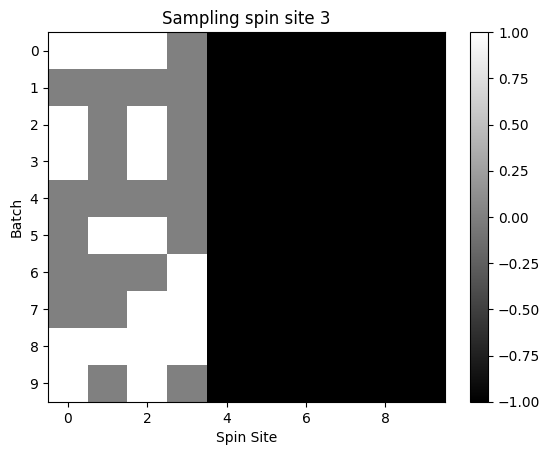

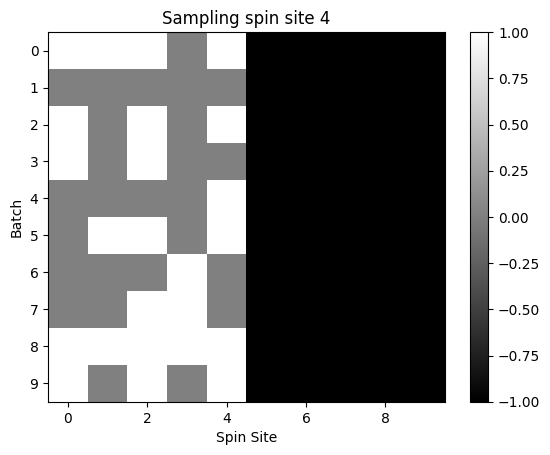

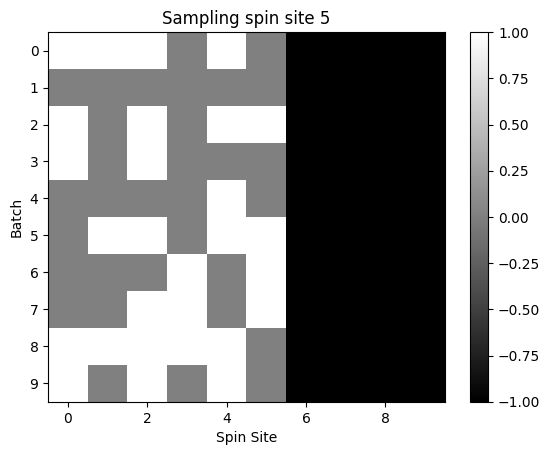

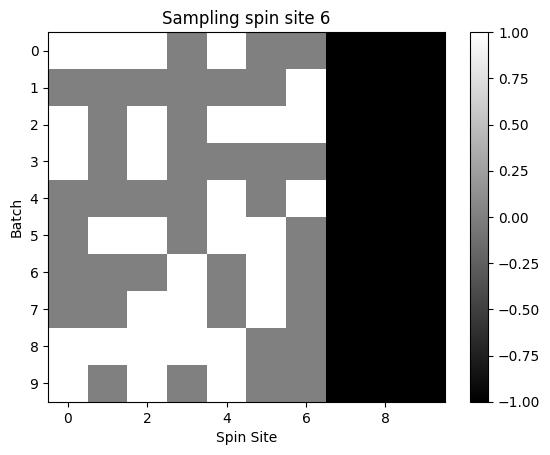

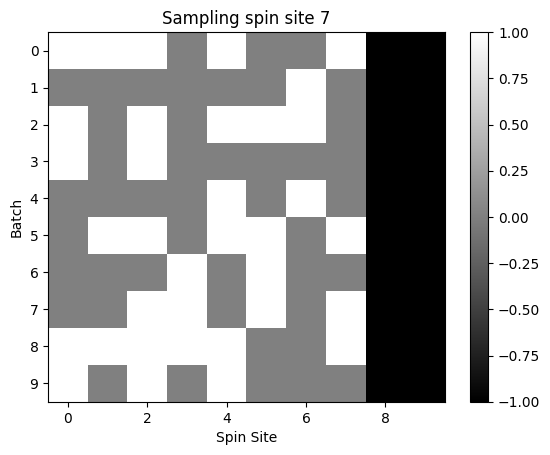

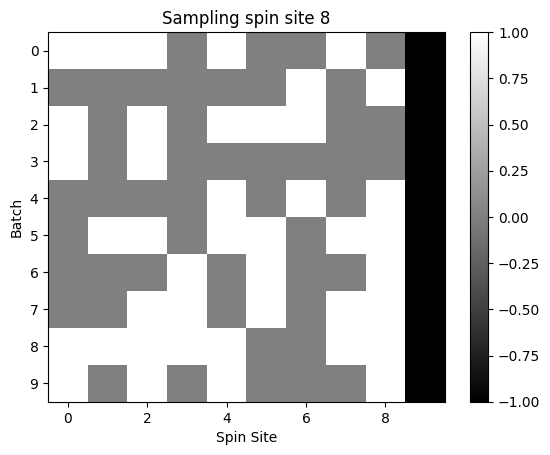

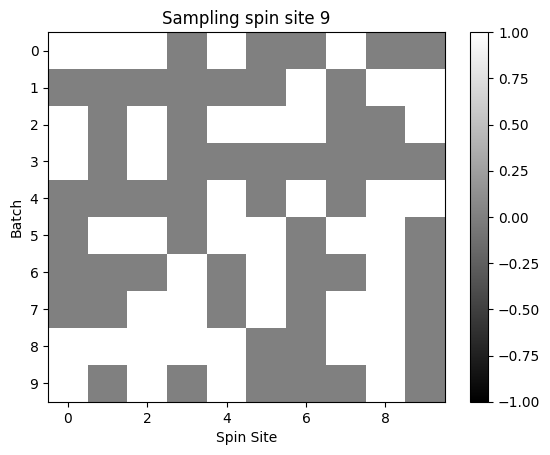

In [9]:
# La fonction ci dessous peut être ajoutée à la classe VAN pour simplifier le code 
# sans le plotting

spin_size = 10
batch_size = 10

mymodel = VAN(spin_size, torch.sigmoid)
spins =  - torch.ones((batch_size, spin_size))
for spin_site in range(spin_size):
    params_Bernoulli = mymodel(spins)
    spins_at_site = Bernoulli(params_Bernoulli[:, spin_site]).sample()
    spins[:, spin_site] = spins_at_site

    plt.figure()
    plt.title('Sampling spin site ' + str(spin_site))
    plt.imshow(spins, vmin=-1, vmax=1, cmap='gray', aspect='auto')
    plt.xlabel('Spin Site')
    plt.ylabel('Batch')
    plt.yticks(np.arange(0, batch_size, 1))
    plt.colorbar()


## 2. Trying training

In [4]:
def log_prob_target(spins):
    ''''
    Compute the log probability of the target distribution
     spin confirgurations mostly up more likely (* 0.8) than mostly down (* 0.2)
    '''
    log_probs = torch.ones(spins.shape[0]) * np.log(0.2)
    log_probs[spins.mean(-1) > 0.5] = np.log(0.8)
    return log_probs - np.log(2 ** (spin_size -1)) 

In [11]:
spin_size = 15
mymodel = VAN(spin_size, torch.sigmoid)

losses = train(mymodel, log_prob_target,  n_iter=1000, lr=1e-3, batch_size=10000)

Epoch 0: 2.2547640800476074
Epoch 100: 1.5170872211456299
Epoch 200: 1.0964667797088623
Epoch 300: 0.7883580923080444
Epoch 400: 0.6073211431503296
Epoch 500: 0.47376444935798645
Epoch 600: 0.3708440661430359
Epoch 700: 0.2899099290370941
Epoch 800: 0.23592470586299896
Epoch 900: 0.16632592678070068


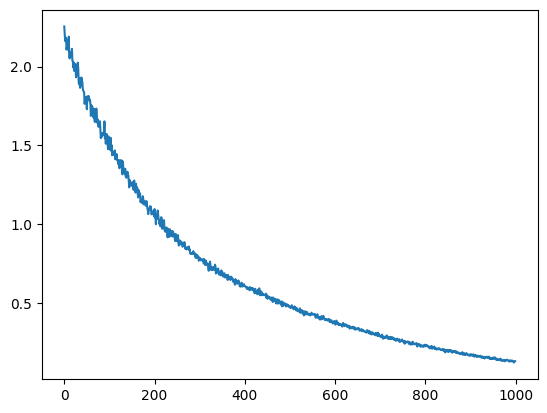

In [12]:
plt.plot(losses)

(array([3309.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6691.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

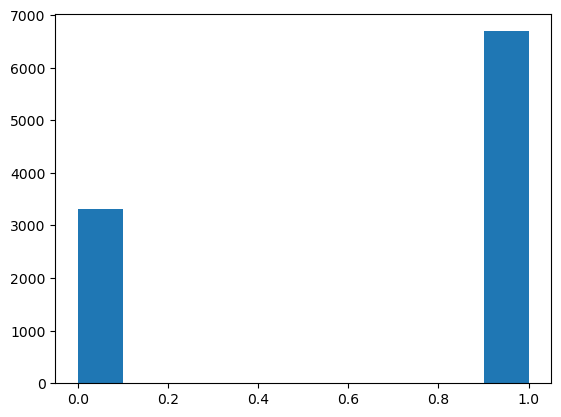

In [7]:
samples = mymodel.sample(10000)

plt.hist((samples.mean(-1) > 0.5) * 1)

## 3. 2D Ising model on a LxL lattice with periodic boundary conditions

Here you have a code of someone who simulated with Monte Carlo the Ising model and followed the mean value of the spin: https://github.com/lukepolson/youtube_channel/blob/main/Python%20Metaphysics%20Series/vid14.ipynb

There is a phase transition: for low temperatures, the distribution of the spins is bimodal, spins are either mostly up or mostly down. 
For high temperatures, the spins are less and less correlated and the mean value of the spins is close to 0.

Can you reproduce the behavior of the mean value of the spins? m(T)

In [7]:
#https://github.com/wdphy16/stat-mech-van/blob/master/src_ising/ising.py
# 2D classical Ising model

def energy(sample):
    term = sample[:, :, 1:, :] * sample[:, :, :-1, :]
    term = term.sum(dim=(1, 2, 3))
    output = term
    term = sample[:, :, :, 1:] * sample[:, :, :, :-1]
    term = term.sum(dim=(1, 2, 3))
    output += term

    # boundary == 'periodic':
    term = sample[:, :, 0, :] * sample[:, :, -1, :]
    term = term.sum(dim=(1, 2))

    output += term
    term = sample[:, :, :, 0] * sample[:, :, :, -1]
    term = term.sum(dim=(1, 2))
    output += term

    return - output
